The class AnnoMI handles the cleaning, remapping of the topics, as well as the cleaning and
abbreviations removal of the utterances text. First, we import the necessaries libraries

In [1]:
import sys

import os
import json
import pickle
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.path.join(os.pardir))

from fair_annomi.data_processing.dataset import AnnoMI

The method `prepare_new_dataset` transforms the old AnnoMI in the new one (topic remapped and
utterances text cleaned).

The method `train_test_split` splits the data in train and test (as Pandas dataframes) such
that the topics and the `target_cols` (parameter that represents the list of columns used as
targets for prediction, default = ['client_talk_type', 'main_therapist_behaviour']) are
perfectly distributed in the train and test sets according to the selected `test_size`
(default=0.2  *20%*)

**PARAMETERS**

In [2]:
unprocessed = False  # if True uses unprocessed dataset (i.e., the utterance text is not cleaned) otherwise the processed dataset
test_size = 0.2  # 20%
min_tokens = 5
relevance_label_field = "mi_quality"

In [3]:
client_col = "client_talk_type"
therapist_col = "main_therapist_behaviour"

In [4]:
ami = AnnoMI()
dataset = ami.unprocessed_dataset() if unprocessed else ami.processed_dataset()

dataset['token_len'] = dataset['utterance_text'].str.strip().str.split(' ').apply(len)
dataset = dataset[(dataset.token_len >= min_tokens)].reset_index(drop=True)

In [9]:
if relevance_label_field == 'mi_quality':
    topic_mi_quality_gby = dataset.groupby(['topic', 'mi_quality']).count()
    dataset = dataset[
        dataset.topic.isin(list(filter(
            lambda x: 'high' in topic_mi_quality_gby.loc[x].index and 'low' in topic_mi_quality_gby.loc[x].index,
            dataset['topic'].unique()
        )))
    ].reset_index(drop=True)
dataset.shape

(3948, 13)

In [10]:
dataset.mi_quality = dataset.mi_quality.map({'high': 1, 'low': 0})

In [11]:
count_topic_miq = dataset.groupby(['topic', 'mi_quality']).count()[['token_len']]
count_topic_miq = count_topic_miq / len(dataset) * 100
count_topic_miq = count_topic_miq.applymap(lambda x: f'{x:.2f}%').reset_index()
count_topic_miq.rename(columns={'token_len': '', 'topic': 'Topic', 'mi_quality': 'MI Quality'}, inplace=True)
count_topic_miq.pivot('Topic', 'MI Quality', '').to_latex(f'topic_distribution_over_topics.tex')

In [12]:
only_therapist_mask = dataset[client_col].isna()

client_dataset = dataset[~only_therapist_mask]
client_dataset = client_dataset.drop(therapist_col, axis=1)

therapist_dataset = dataset[only_therapist_mask]
therapist_dataset = therapist_dataset.drop(client_col, axis=1)

Add ids to the query (topic) and document (utterance_text) fields

In [13]:
unique_topics = therapist_dataset.topic.unique()
topics_map = dict(zip(unique_topics, range(1, len(unique_topics) + 1)))

unique_documents = therapist_dataset.utterance_text.unique()
documents_map = dict(zip(unique_documents, range(1, len(unique_documents) + 1)))

therapist_dataset['topic_id'] = therapist_dataset.topic.map(topics_map)
therapist_dataset['utterance_text_id'] = therapist_dataset.utterance_text.map(documents_map)

if not os.path.exists('topics_map.json'):
    with open('topics_map.json', 'w') as f:
        json.dump(topics_map, f, indent=4)

if not os.path.exists('documents_map.json'):
    with open('documents_map.json', 'w') as f:
        json.dump(documents_map, f, indent=4)

Split data in train and test, separately for client and therapist

In [14]:
client_train, client_test, client_encoder = ami.train_test_split_target_topic_distributed(client_dataset, target_col=client_col, test_size=test_size, encode_target=True)
client_encoder.classes_

array(['change', 'neutral', 'sustain'], dtype=object)

In [15]:
therapist_train, therapist_test, therapist_encoder = ami.train_test_split_target_topic_distributed(therapist_dataset, target_col=therapist_col, test_size=test_size, encode_target=True)
therapist_encoder.classes_

array(['other', 'question', 'reflection', 'therapist_input'], dtype=object)

In [17]:
epochs = 15

In [19]:
import keras
import matchzoo as mz
import tensorflow_ranking as tfr

mz_train = therapist_train[['topic', 'utterance_text', relevance_label_field, 'topic_id', 'utterance_text_id']].rename(columns={
    'topic': 'text_left',
    'utterance_text': 'text_right',
    relevance_label_field: 'label',
    'topic_id': 'id_left',
    'utterance_text_id': 'id_right'
}).reset_index(drop=True)

mz_train = mz.pack(mz_train)

mz_test = therapist_test[['topic', 'utterance_text', relevance_label_field, 'topic_id', 'utterance_text_id']].rename(columns={
    'topic': 'text_left',
    'utterance_text': 'text_right',
    relevance_label_field: 'label',
    'topic_id': 'id_left',
    'utterance_text_id': 'id_right'
}).reset_index(drop=True)

mz_test = mz.pack(mz_test)

Using TensorFlow backend.


In [ ]:
from matchzoo.auto.preparer import Preparer
import copy

# HBMP, ESIM, BiMPM si può eseguire, ci mette 2 ore e mezzo circa
for model_class in mz.models.list_available():
    try:
        print(model_class)
        if os.path.exists(f'{model_class.__name__}_{relevance_label_field}_predictions.npy'):
            continue
            
        if model_class in [mz.models.dssm.DSSM,
                           mz.models.cdssm.CDSSM,
                           mz.models.match_pyramid.MatchPyramid,
                           mz.models.drmm.DRMM,
                           mz.models.anmm.ANMM,
                           mz.contrib.models.diin.DIIN,
                           mz.models.mvlstm.MVLSTM,
                           mz.contrib.models.match_srnn.MatchSRNN,
                           mz.contrib.models.match_lstm.MatchLSTM,
                           mz.models.conv_knrm.ConvKNRM,
                           mz.contrib.models.esim.ESIM,
                           mz.contrib.models.bimpm.BiMPM]:
            continue

        ranking_task = mz.tasks.Ranking(loss=mz.losses.RankCrossEntropyLoss(num_neg=2))
        ranking_task.metrics = [
            mz.metrics.NormalizedDiscountedCumulativeGain(k=5),
            mz.metrics.MeanReciprocalRank()
        ]

        preprocessor = model_class.get_default_preprocessor()

        if isinstance(preprocessor, (mz.preprocessors.BasicPreprocessor, mz.preprocessors.CDSSMPreprocessor, mz.preprocessors.DIINPreprocessor)):
            fixed_length_left = max(mz_train.append_text_length().frame()['length_left'].max(), mz_test.append_text_length().frame()['length_left'].max())
            fixed_length_right = max(mz_train.append_text_length().frame()['length_right'].max(), mz_test.append_text_length().frame()['length_right'].max())

            kwargs = {'fixed_length_left': fixed_length_left, 'fixed_length_right': fixed_length_right}
            if isinstance(preprocessor, mz.preprocessors.BasicPreprocessor):
                kwargs['filter_low_freq'] = 1
            elif isinstance(preprocessor, mz.preprocessors.DIINPreprocessor):
                kwargs['fixed_length_word'] = 20
            elif isinstance(preprocessor, mz.preprocessors.CDSSMPreprocessor):
                kwargs['fixed_length_right'] = 128

            preprocessor = preprocessor.__class__(**kwargs)

        preprocessor.context['optimizer'] = keras.optimizers.Adam(learning_rate=0.5)

        model, preprocessor, data_generator_builder, embedding_matrix = mz.auto.prepare(
            task=ranking_task,
            model_class=model_class,
            preprocessor=preprocessor,
            data_pack=mz_train,
        )
        train_processed = preprocessor.transform(mz_train, verbose=0)
        test_processed = preprocessor.transform(mz_test, verbose=0)

        train_gen = data_generator_builder.build(train_processed, batch_size=32)
        test_gen = data_generator_builder.build(copy.deepcopy(test_processed), batch_size=32)

        test_x, test_y = test_gen[:]
        evaluate = mz.callbacks.EvaluateAllMetrics(model, x=test_x, y=test_y, batch_size=len(test_x))
        
        best_eval_res = 0
        for epoch in range(epochs):
            model.fit_generator(train_gen, epochs=epoch + 1, workers=16, initial_epoch=epoch)
            eval_results = model.evaluate_generator(train_gen)
            print(eval_results)
            if eval_results[ranking_task.metrics[0]] > best_eval_res:
                best_eval_res = eval_results[ranking_task.metrics[0]]
                predictions = model.predict(test_x)
                np.save(os.path.join(os.pardir, 'predictions', f'{model_class.__name__}_{relevance_label_field}_predictions.npy'), predictions)

                try:
                    predictions_test_mz = model.predict(test_processed.unpack()[0])
                    np.save(os.path.join(os.pardir, 'predictions', f'{model_class.__name__}_{relevance_label_field}_predictions_test_mz.npy'), predictions_test_mz)
                except Exception as e:
                    print(e)
    except Exception as e:
        print(e)


In [20]:
from sklearn.metrics import ndcg_score

pred_files = os.listdir(os.path.join(os.pardir, 'predictions')) + [os.path.join(os.pardir, 'predictions', 'tfrbert', f'bert_{relevance_label_field}_predictions.csv')]
topk = [3, 5, 10]
result = []
cols = ['Topic', 'Model', 'Value', 'Metric']
inv_topics_map = {v: k for k, v in topics_map.items()}
for file in pred_files:
    if (os.path.splitext(file)[1] == '.npy' and relevance_label_field in file) or f'bert_{relevance_label_field}_predictions' in file:
        if 'test_mz' not in file and os.path.exists(file.split('_')[0] + f'_{relevance_label_field}_predictions_test_mz.npy'):
            continue
        
        if f'bert_{relevance_label_field}_predictions' not in file:
            pred = np.load(file)
            test_df = mz_test.frame().copy()
            test_df['pred'] = pred.flatten()
            test_df.rename(columns={'text_left': 'Topic', 'label': 'Relevance'}, inplace=True)
        else:
            test_df = pd.read_csv(file).rename(columns={'prediction': 'pred', 'topic': 'Topic', relevance_label_field: 'Relevance'}).fillna(0)
        for k in topk:
            for topic, topic_df in test_df.groupby('Topic'):
                ndcg = ndcg_score([topic_df['Relevance']], [topic_df['pred']], k=k)
                if f'bert_{relevance_label_field}_predictions' not in file:
                    model_name = file.split(f'_{relevance_label_field}_predictions')[0]
                else:
                    model_name = 'TFR BERT'
                result.append([topic, model_name, ndcg, f'NDCG@{k}'])
result_df = pd.DataFrame(result, columns=cols)

In [21]:
result_df

,Topic,Model,Value,Metric
0,adhering to medical procedure,ArcII,0.469279,NDCG@3
1,asthma management,ArcII,1.000000,NDCG@3
2,compliance with rules,ArcII,1.000000,NDCG@3
3,diabetes management,ArcII,1.000000,NDCG@3
4,managing life,ArcII,1.000000,NDCG@3
...,...,...,...,...
211,diabetes management,TFR BERT,0.962963,NDCG@10
212,managing life,TFR BERT,0.955556,NDCG@10
213,reducing alcohol consumption,TFR BERT,0.812500,NDCG@10
214,reducing alcohol consumption|smoking cessation,TFR BERT,0.624051,NDCG@10


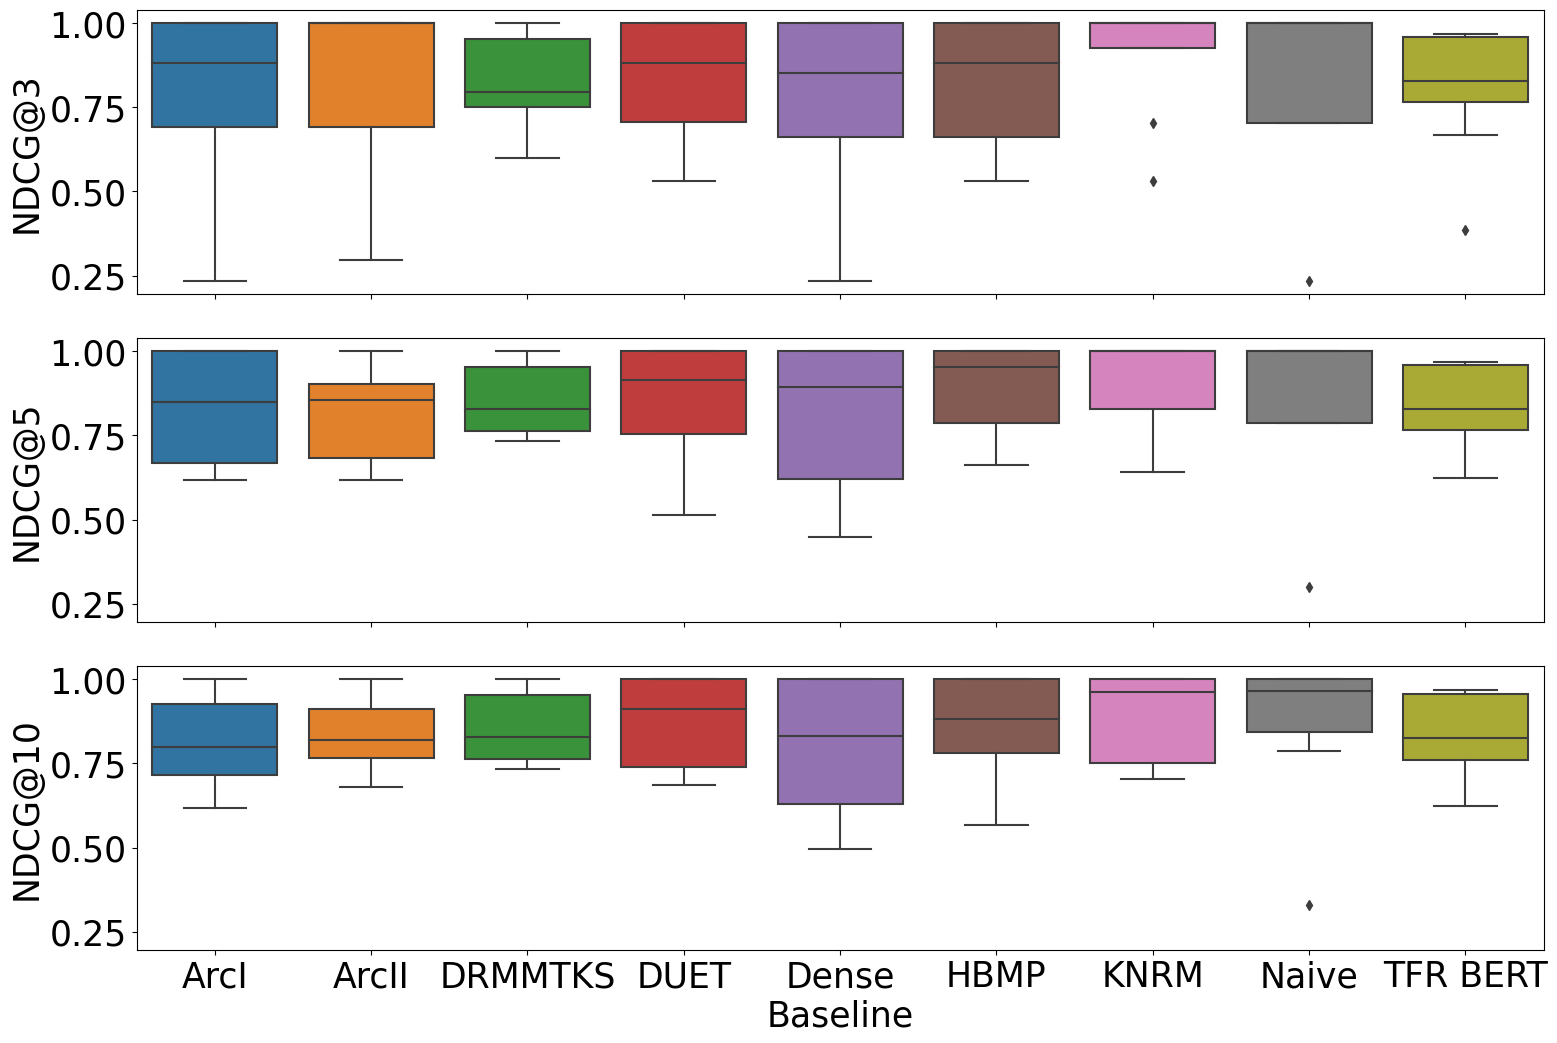

In [23]:
res_df = result_df.replace('DenseBaseline', 'Dense\nBaseline')
metric_gby = res_df.groupby('Metric')
plt.rcParams.update({'font.size': 25})
fig, axs = plt.subplots(len(metric_gby.groups), 1, sharey=True, sharex=True, figsize=(16, 11))
for i, metric in enumerate(sorted(metric_gby.groups.keys(), key=lambda x: int(x.split('@')[1]))):
    metric_df = metric_gby.get_group(metric)
    sns.boxplot(x='Model', y='Value', data=metric_df.sort_values('Model'), ax=axs[i])
    axs[i].set_ylabel(metric)
    axs[i].set_xlabel('')
fig.tight_layout()
fig.savefig(f'({relevance_label_field})_NDCG_distribution_over_topics_per_model.png')

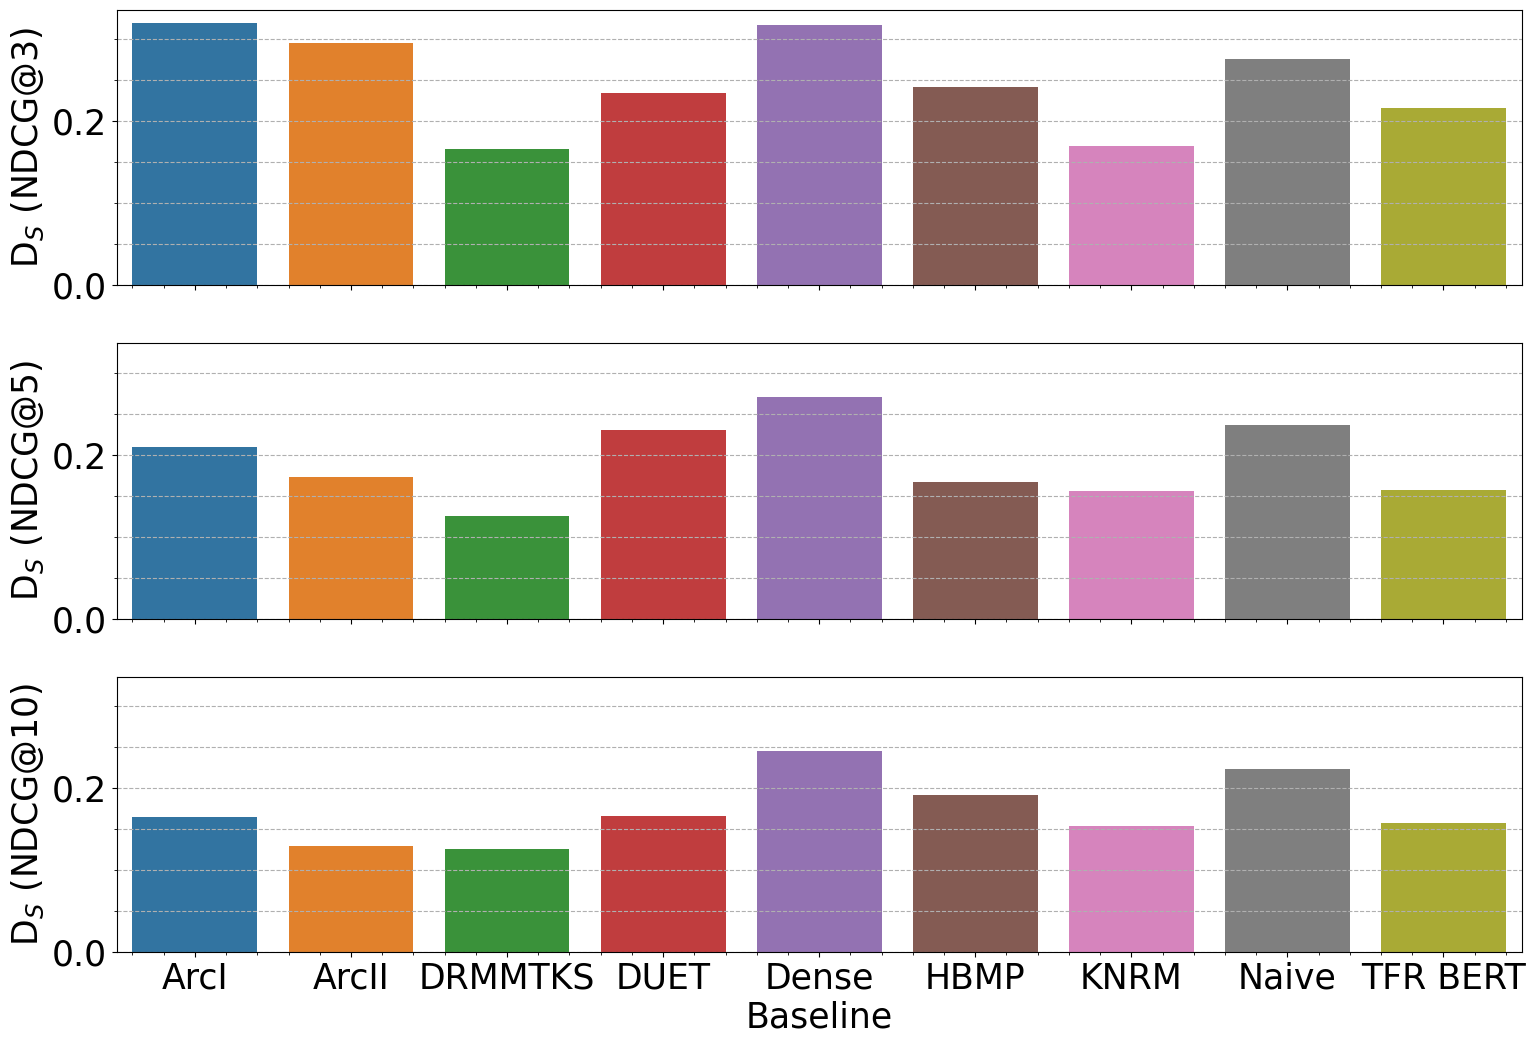

In [24]:
import itertools

metric_gby = res_df.groupby('Metric')
fig, axs = plt.subplots(len(metric_gby.groups), 1, sharex=True, sharey=True, figsize=(16, 11))
for i, metric in enumerate(sorted(metric_gby.groups.keys(), key=lambda x: int(x.split('@')[1]))):
    metric_df = metric_gby.get_group(metric)
    diversity_data = []
    for model_name, model_df in metric_df.groupby('Model'):
        diversity = []
        topic_mdf = model_df.set_index('Topic')
        for t1, t2 in itertools.combinations(topic_mdf.index, 2):
            diversity.append(np.abs(topic_mdf.loc[t1, 'Value'] - topic_mdf.loc[t2, 'Value']))
        diversity_data.append([model_name, np.mean(diversity)])
    plot_df = pd.DataFrame(diversity_data, columns=['Model', 'Value'])
    sns.barplot(x='Model', y='Value', data=plot_df.sort_values('Model'), ax=axs[i])
    axs[i].set_ylabel(f'D$_S$ ({metric})')
    axs[i].set_xlabel('')
    axs[i].minorticks_on()
    axs[i].grid(axis='y', ls='--', which='both')
fig.tight_layout()
fig.savefig(f'({relevance_label_field})_NDCG_diversity_per_model.png')

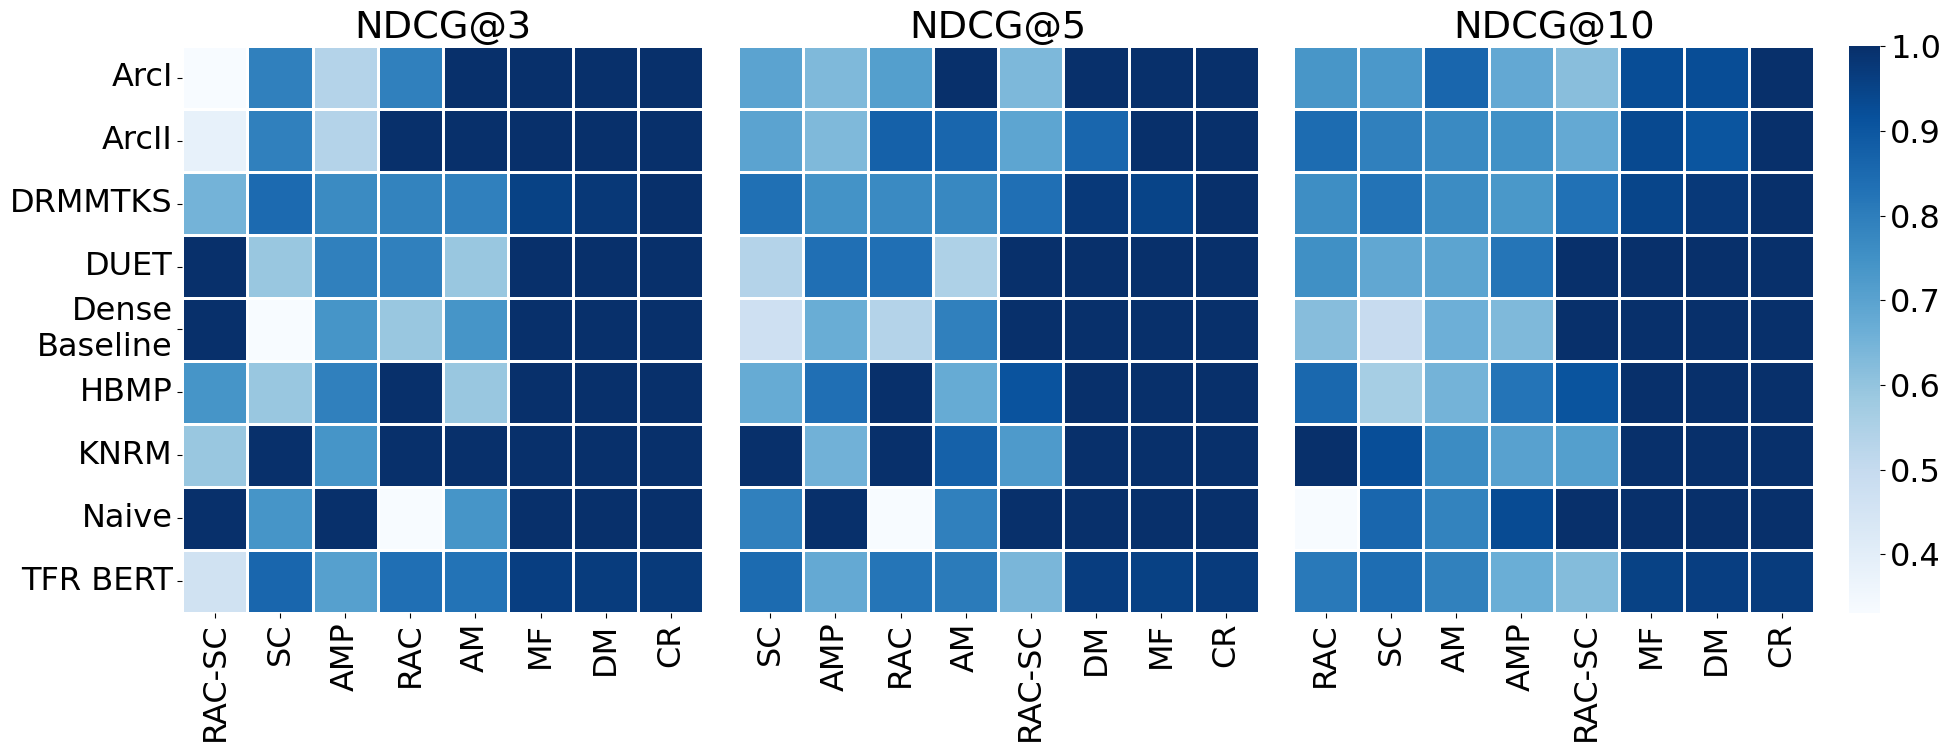

In [64]:
topics_short_mapping = {
    'adhering to medical procedure': 'AMP',
    'asthma management': 'AM',
    'compliance with rules': 'CR',
    'diabetes management': 'DM',
    'managing life': 'MF',
    'reducing alcohol consumption': 'RAC',
    'reducing alcohol consumption|smoking cessation': 'RAC-SC',
    'smoking cessation': 'SC'
}

plt.rcParams.update({'font.size': 23})

rdf = res_df.copy()
rdf.Topic = rdf.Topic.map(topics_short_mapping)
metric_gby = rdf.groupby('Metric')
fig, axs = plt.subplots(1, len(metric_gby.groups) + 1, figsize=(20, 8), gridspec_kw=dict(width_ratios=[0.33, 0.33, 0.33, 0.02]))
for ax in axs[1:-1]:
    ax.sharey(axs[0])
    ax.yaxis.set_visible(False)
for i, metric in enumerate(sorted(metric_gby.groups.keys(), key=lambda x: int(x.split('@')[1]))):
    pivot_df = metric_gby.get_group(metric).pivot('Model', 'Topic', 'Value')
    ndcg_mean_per_topic = pivot_df.mean(axis=0).sort_values(ascending=True)
    cols_order = ndcg_mean_per_topic.index
    sns.heatmap(pivot_df[cols_order], ax=axs[i], cbar=i == len(metric_gby.groups) - 1, cbar_ax=axs[-1], cmap="Blues", linewidth=1)
    axs[i].set_title(metric)
    axs[i].set_xlabel('')
axs[0].set_ylabel('')
fig.tight_layout()
fig.savefig(f'({relevance_label_field})_NDCG_heatmap_per_topic.png')